# Import python packages

In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.utils import to_categorical

SEED = 7
np.random.seed(SEED)

Using TensorFlow backend.


# Define parameters and load dataset

In [4]:
MODEL_NAME = "CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32"

if experiment is not None:
    experiment.set_name(MODEL_NAME)
    experiment.set_filename(MODEL_NAME +'.ipynb')

Word2Vec_MODEL_NAME = "Word2Vec_No_Indexed_3_iters_5_negative_1_window"  #################

TEST_SIZE = 0.2
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
class_names = ['P2P', 'C2P', 'P2C']
num_classes = len(class_names)
DATA_PATH = '../../Data/'
MODELS_PATH = '../../Models/'
RESULTS_PATH = '../../Results/'

DATA = "caida_s1_tor"
dataset = np.load(DATA_PATH + DATA + "_dataset.npy")
labels = np.load(DATA_PATH + DATA + "_labels.npy")

print(dataset.shape, labels.shape)

(580762, 2) (580762,)
(113378, 2) (113378,)


In [5]:
print(dataset[0])

['1' '11537']


In [8]:
ASN_set = set()
for tor in dataset:
    ASN_set.add(tor[0])
    ASN_set.add(tor[1])

print(len(ASN_set))

58679


In [9]:
from collections import Counter
c_caida = Counter(labels)
print(c_caida)

Counter({0: 343952, 2: 118405, 1: 118405})


# Load Word2Vec embedding

In [10]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load(MODELS_PATH + Word2Vec_MODEL_NAME + ".word2vec")
emdeddings = word2vec_model.wv.syn0
total_ASNs, embedding_vecor_length = emdeddings.shape
print(total_ASNs, embedding_vecor_length)

62525 32


/home/tal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


## Generate indexed data with fixed length

In [11]:
def asn2idx(asn):
    return word2vec_model.wv.vocab[asn].index
def idx2asn(idx):
    return word2vec_model.wv.index2word[idx]

def dataset_asn2idx(dataset):
    dataset_idx = np.zeros([len(dataset), 2], dtype=np.int32)

    for i, pair in enumerate(dataset):
            dataset_idx[i, 0] = asn2idx(pair[0])
            dataset_idx[i, 1] = asn2idx(pair[1])
    return dataset_idx

def dataset_idx2asn(dataset_idx):
    dataset_asn = np.zeros([len(dataset_idx), 2], dtype = np.dtype('U6'))

    for i, pair in enumerate(dataset_idx):
            dataset_asn[i, 0] = idx2asn(pair[0])
            dataset_asn[i, 1] = idx2asn(pair[1])
    return dataset_asn
        
dataset = dataset_asn2idx(dataset)
print(dataset.shape)

(580762, 2)


# Generate training and test sets

## Shuffle dataset

In [12]:
from sklearn.utils import shuffle
indices = np.arange(len(dataset))
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]
# dataset, labels = shuffle(dataset, labels, random_state=7)

## Train-Test split

In [13]:
indices = np.arange(len(dataset))
x_training, x_test, indices_training, indices_test = train_test_split(dataset, indices, test_size=TEST_SIZE)
y_training = labels[indices_training]
y_test = labels[indices_test]

del dataset, labels

In [14]:
print(x_training.shape, y_training.shape)
print(x_test.shape, y_test.shape)

print(1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print(training_c, test_c)

(464609, 2) (464609,)
(116153, 2) (116153,)
0.7999989668745545
Counter({0: 275086, 1: 94895, 2: 94628}) Counter({0: 68866, 2: 23777, 1: 23510})


# Define and run NN model
## Define model

In [15]:
embedding_trainable = False
if experiment is not None:
    experiment.log_parameter("embedding_trainable", embedding_trainable)
input_length = 2

model = Sequential()
model.add(Embedding(total_ASNs, embedding_vecor_length, input_length=input_length,
                    weights=[emdeddings], trainable=embedding_trainable))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((model.output_shape[2],model.output_shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((model.output_shape[2],model.output_shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 32)             2000800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 2)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 2)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 32)            224       
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 16)            0         
_________________________________________________________________
max_

In [15]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file=RESULTS_PATH + MODEL_NAME + "_" + 'model.png')

## convert class vectors to binary class matrices

In [16]:
y_training_vector = to_categorical(y_training, num_classes)
y_test_vector = to_categorical(y_test, num_classes)

## Use class_weight to deal with unbalanced dataset

In [17]:
from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', list(range(num_classes)), y_training)
# print(class_weights)
class_weights = None

## Fit model

In [18]:
checkpointer_loss = ModelCheckpoint(filepath= MODELS_PATH + MODEL_NAME + '_loss.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= MODELS_PATH + MODEL_NAME + '_acc.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

callbacks = [checkpointer_loss,checkpointer_acc] #tensorboard

In [18]:
import math

epochs = 40 #################################   3  ##########
if experiment is not None:
    experiment.log_parameter("epochs", epochs)

batch_size = 64
if experiment is not None:
    experiment.log_parameter("batch_size", batch_size)

steps_per_epoch = math.ceil(len(x_training)/batch_size)
if experiment is not None:
    experiment.log_parameter("steps_per_epoch", steps_per_epoch)

val_batch_size = 1024
if experiment is not None:
    experiment.log_parameter("val_batch_size", val_batch_size)

validation_steps = math.ceil(len(x_test)/val_batch_size)
if experiment is not None:
    experiment.log_parameter("validation_steps", validation_steps)

def val_generator(features, labels, val_batch_size):
    index = 0
    while True:
        index += val_batch_size
        batch_features, batch_labels = features[index-val_batch_size:index], labels[index-val_batch_size:index]
        if index >= len(features):
            index = 0
        yield batch_features, batch_labels
        
def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index-batch_size:len(features)], features[0:index-len(features)], axis=0)
            batch_labels = np.append(labels[index-batch_size:len(features)], labels[0:index-len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index-batch_size:index], labels[index-batch_size:index]

In [20]:
if experiment is not None:
    with experiment.train():
        history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
                        epochs=epochs, callbacks=callbacks, class_weight=class_weights,
                        validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
                        validation_steps=validation_steps)
else:
    history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
                        epochs=epochs, callbacks=callbacks, class_weight=class_weights,
                        validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
                        validation_steps=validation_steps)
    

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
7260/7260 [==============================] - 37s 5ms/step - loss: 0.2786 - acc: 0.8976 - val_loss: 0.2332 - val_acc: 0.9177

Epoch 00001: val_loss improved from inf to 0.23322, saving model to ../../Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.91774, saving model to ../../Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.hdf5
Epoch 2/40
7260/7260 [==============================] - 37s 5ms/step - loss: 0.2127 - acc: 0.9244 - val_loss: 0.2050 - val_acc: 0.9284

Epoch 00002: val_loss improved from 0.23322 to 0.20505, saving model to ../../Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_loss.hdf5

Epoch 00002: val_acc improved from 0.91774 to 0.92843, saving model to ../../Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.hdf5
Epoch 3/40
7260/7260 [==============================] - 37s 5ms/step - loss: 0.1946 - acc: 0.

7260/7260 [==============================] - 26s 4ms/step - loss: 0.1343 - acc: 0.9532 - val_loss: 0.1773 - val_acc: 0.9415

Epoch 00024: val_loss did not improve from 0.17244

Epoch 00024: val_acc did not improve from 0.94165
Epoch 25/40
7260/7260 [==============================] - 25s 3ms/step - loss: 0.1335 - acc: 0.9533 - val_loss: 0.1776 - val_acc: 0.9417

Epoch 00025: val_loss did not improve from 0.17244

Epoch 00025: val_acc improved from 0.94165 to 0.94172, saving model to ../../Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.hdf5
Epoch 26/40
7260/7260 [==============================] - 27s 4ms/step - loss: 0.1326 - acc: 0.9537 - val_loss: 0.1780 - val_acc: 0.9416

Epoch 00026: val_loss did not improve from 0.17244

Epoch 00026: val_acc did not improve from 0.94172
Epoch 27/40
7260/7260 [==============================] - 33s 5ms/step - loss: 0.1318 - acc: 0.9539 - val_loss: 0.1791 - val_acc: 0.9413

Epoch 00027: val_loss did not improve from 0.17244

Epoch 000

# Plot history accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


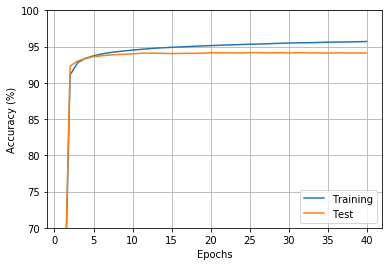

In [21]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


with open(RESULTS_PATH + MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)
    if experiment is not None:
        experiment.log_asset(RESULTS_PATH + MODEL_NAME +  "_accuracy.pkl")
    
# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, smooth([y*100 for y in history.history['acc']],2))
# plt.plot(x, [y*100 for y in history_history['val_acc']])
plt.plot(x, smooth([y*100 for y in history.history['val_acc']],2))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim(70,100) ###########################
plt.legend(['Training', 'Test'], loc='lower right')
plt.grid()
plt.savefig(RESULTS_PATH + MODEL_NAME +  " accuracy history", bbox_inches='tight')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + " accuracy history.png")
plt.show()

# Final evaluation of the model
## Evaluate accuracy over the test set

In [19]:
model.load_weights(MODELS_PATH + MODEL_NAME + '_acc.hdf5')

In [19]:
test_scores = model.evaluate(x_test, y_test_vector, batch_size=val_batch_size, verbose=1)
    
    
print("Accuracy: %.2f%%" % (test_scores[1]*100))

116153/116153 [==============================] - 2s 15us/step
Accuracy: 94.19%


In [20]:
y_test_prediction = model.predict_classes(x_test, batch_size=val_batch_size, verbose=1)

116153/116153 [==============================] - 1s 6us/step


In [21]:
y_training_prediction = model.predict_classes(x_training, batch_size=val_batch_size, verbose=1)

464609/464609 [==============================] - 5s 11us/step


## Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa

In [45]:
p2c = 2
c2p = 1

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])

p2c_training_label_vector = to_categorical([p2c]*len(p2c_training), num_classes)
p2c_training_oposite_label_vector = to_categorical([c2p]*len(p2c_training_oposite), num_classes)

print(p2c_training.shape, p2c_training_oposite.shape, p2c_training_oposite_label_vector.shape)

(65736, 2) (65736, 2) (65736, 3)


In [46]:
p2c_training_scores = model.evaluate(p2c_training, p2c_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_scores[1]*100))

p2c_training_oposite_scores = model.evaluate(p2c_training_oposite, p2c_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores[1]*100))

65736/65736 [==============================] - 2s 30us/step
Accuracy: 99.08%
65736/65736 [==============================] - 2s 29us/step
Accuracy: 95.81%


## Test if by learning (asn1, asn2) -> p2p then (asn2, asn1) -> p2p and vice versa

In [47]:
p2p = 0

p2p_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2p])
p2p_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2p_training])

p2p_training_label_vector = to_categorical([p2p]*len(p2p_training), num_classes)
p2p_training_oposite_label_vector = to_categorical([p2p]*len(p2p_training_oposite), num_classes)

In [48]:
p2p_training_scores = model.evaluate(p2p_training, p2p_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_scores[1]*100))

p2p_training_oposite_scores = model.evaluate(p2p_training_oposite, p2p_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_oposite_scores[1]*100))

14229/14229 [==============================] - 0s 29us/step
Accuracy: 92.09%
14229/14229 [==============================] - 0s 28us/step
Accuracy: 87.49%


## Plot and save a confusion matrix for results over the test set

### Define a function

In [49]:
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow([[100*j for j in i] for i in cm], interpolation='nearest', cmap=cmap)
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

Confusion matrix, without normalization
Normalized confusion matrix


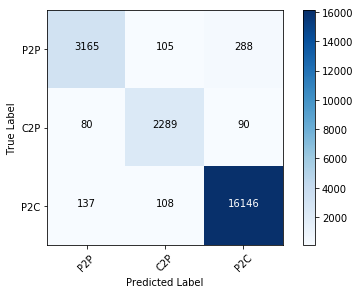

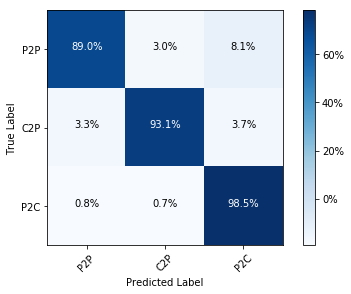

In [50]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization.png', 
                         name='Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=RESULTS_PATH +MODEL_NAME + "_" + 'Normalized_confusion_matrix')

if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'Normalized_confusion_matrix.png',
                         name='Normalized_confusion_matrix.png')

plt.show()

## Plot cm for training set

Confusion matrix, without normalization
Normalized confusion matrix


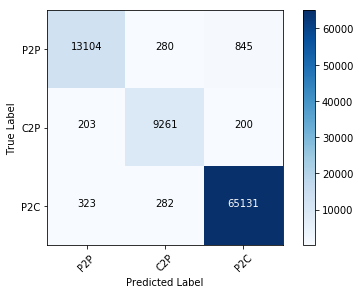

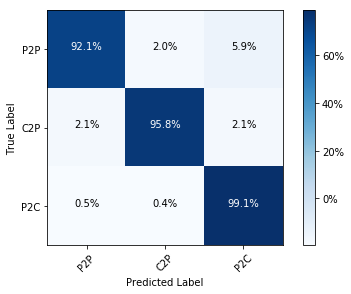

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_training, y_training_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix',
                      fname=RESULTS_PATH +MODEL_NAME + "_" + 'training_Normalized_confusion_matrix')
if experiment is not None:
    experiment.log_image(RESULTS_PATH + MODEL_NAME + "_" + 'training_Normalized_confusion_matrix.png')

plt.show()

# Export the model to a file

In [52]:
model_json = model.to_json()
with open(MODELS_PATH + MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODELS_PATH + MODEL_NAME + '.h5')
print("Save Model")

Save Model


# Export results to a csv file (with original ASNs)
## Define functions

In [26]:
def dataset_idx2asn(dataset, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)

    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        dataset_asn.append(route_asn) 
    return dataset_asn

def dataset_idx2asn_labels(dataset, labels, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        dataset_asn.append(route_asn) 
    return dataset_asn


def dataset_idx2asn_labels_predictions(dataset, labels, predictions, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
        predictions = np.take(predictions, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        route_asn.append(class_names[predictions[i]])
        dataset_asn.append(route_asn) 
    return dataset_asn

def dataset_idx2asn_labels_predictions_prob(dataset, labels, predictions, prob, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
        predictions = np.take(predictions, indexes, axis=0)
        prob = np.take(prob, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        route_asn.append(class_names[predictions[i]])
        for p in prob[i]:
            route_asn.append(round(p,4))
        
        dataset_asn.append(route_asn) 
    return dataset_asn

import csv
def export_csv(dataset, csv_name, header_type='with_gt'):
    header_types = {
        'reg': ["AS1", "AS2", "Label", "Prediction", "P2P_Prob", "C2P_Prob", "P2C_Prob"],
        'with_gt': ["AS1", "AS2", "Label", 'GT', "Prediction", "P2P_Prob", "C2P_Prob", "P2C_Prob"]
    }
    
    with open(csv_name + '.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        if header_type is not None:
            csv_writer.writerow(header_types[header_type])
        for row in dataset:
            csv_writer.writerow(row)

## Load a relevant dataset {all, misclassified, decided, undecided} and get model predictions

In [27]:
y_test_prob = model.predict_proba(x_test, batch_size=val_batch_size, verbose=1)
# y_training_prob = model.predict_proba(x_training, batch_size=val_batch_size, verbose=1)

116153/116153 [==============================] - 1s 7us/step


In [28]:
# # Create test misclassified dataset
x_test_misclassified = np.asarray([route for i,route in enumerate(x_test) if y_test[i] != y_test_prediction[i]])
y_test_misclassified_prediction = np.asarray([label for i,label in enumerate(y_test_prediction) if y_test[i] != y_test_prediction[i]])
y_test_misclassified = np.asarray([label for i,label in enumerate(y_test) if y_test[i] != y_test_prediction[i]])
y_test_misclassified_prob = np.asarray([prob for i,prob in enumerate(y_test_prob) if y_test[i] != y_test_prediction[i]])

print(len(x_test_misclassified), len(y_test_misclassified_prediction), len(y_test_misclassified))
print(y_test_misclassified_prob.shape)

6753 6753 6753 6753
(6753, 3)


In [29]:
dataset_test_misclassified = dataset_idx2asn_labels_predictions_prob(x_test_misclassified, y_test_misclassified,
                                        y_test_misclassified_prediction, y_test_misclassified_prob)
export_csv(dataset_test_misclassified, RESULTS_PATH + MODEL_NAME + "_test_misclassified")

In [30]:
y_test_misclassified_prob_max = np.array([y_test_misclassified_prob[i][pred] for i, pred in enumerate(y_test_misclassified_prediction)])
print(y_test_misclassified_prob_max[:10])

[0.96811545 0.56680095 0.8645542  0.9803387  0.7388056  0.9407794
 0.9536408  0.9981211  0.9132586  0.5935503 ]


In [31]:
indexes = np.array(list(range(len(x_test_misclassified))))
indexes = [x for _, x in sorted(zip(y_test_misclassified_prob_max,indexes), reverse=True)]
print(indexes[:100])
print(y_test_misclassified_prob_max[indexes[0]])

[4085, 3980, 678, 1566, 6738, 5789, 2122, 72, 679, 1927, 1261, 1043, 5839, 30, 2664, 4697, 4711, 3824, 561, 1362, 3325, 5737, 5792, 2048, 2549, 5591, 323, 2706, 3973, 2506, 4700, 2961, 5761, 6244, 5950, 947, 4891, 4096, 1737, 3749, 6101, 4034, 700, 1148, 5064, 2071, 2585, 6191, 5199, 2559, 5444, 1973, 1135, 5710, 3573, 3462, 3127, 5061, 1801, 1145, 424, 5363, 2954, 5132, 2708, 2187, 2422, 3601, 6265, 1307, 4008, 456, 1946, 3773, 5095, 2243, 2483, 1680, 6060, 6435, 3247, 3258, 3892, 6653, 673, 404, 5873, 3531, 2785, 5949, 711, 1414, 3602, 2305, 1110, 6392, 6143, 2118, 2864, 3431]
0.999998


## Export Results

In [ ]:
dataset_misclassified = dataset_idx2asn_and_labels(x_test_misclassified, y_test_misclassified_prediction)
export_csv(dataset_misclassified, RESULTS_PATH + MODEL_NAME + "_misclassified")